# Decomposition Methods on a spectral grid

RUN FIRST CELL FOR ALL SUBSEQUENT CELLS TO WORK :)

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import fnmatch
import itertools
plt.style.use('Solarize_Light2')

# Creating the flux grid space
files = os.listdir('short_spec_cv_grid/') # list of files in directory
sorted_files = []
for num in range(1,126): # run number ranges
    if len(str(num)) == 1: # adding 0 to single digit run numbers
        run = f'run0{num}_'
    else:
        run = f'run{num}_'
    file = fnmatch.filter(files, run+'*') # matching file with loop run number
    sorted_files.append('short_spec_cv_grid/'+str(file[0])) # files sorted in order of run number

# wavelengths in angstroms ordered by reversing list 
wavelengths = np.loadtxt(sorted_files[0], usecols=1, skiprows=81)[::-1]
wavelength_range = (1510,1590) # set desired wavelength range
wave_mask = (wavelengths > wavelength_range[0]) & (wavelengths < wavelength_range[1]) # mask for wavelength range
wavelengths = wavelengths[wave_mask] # updating to new wavelength range
grid = np.empty((len(sorted_files), len(wavelengths))) # empty array to store flux values
for i in range(len(sorted_files)):
    flux = np.loadtxt(sorted_files[i], usecols=16, skiprows=81)[::-1] # flux values for each file
    grid[i] = flux[wave_mask] # adding fluxes into the grid

# Creating the unique combinations of grid points (len(125))   
grid_points = np.array([np.log10([4.e-11, 1.e-10, 4.e-10, 1.e-09, 3.e-09]),[2, 5, 8, 12, 16], [1, 1.5, 2, 2.5, 3]])
unique_combinations = []
for i in itertools.product(*grid_points):
    unique_combinations.append(list(i))

# Normalising, centring and whitening the grid
norm_factor = np.mean(grid, axis=1)[:,None] # normalisation factor
normalised_grid = grid/norm_factor # normalising the grid
centre_factor = np.mean(normalised_grid, axis=0) # centring factor
centred_grid = normalised_grid - centre_factor # centring the grid
whiten_factor = np.std(centred_grid, axis=0) # whitening factor
whitened_grid = centred_grid/whiten_factor # whitening the grid



### ALL DIFFERENT DECOMPOSITION METHODS

In [84]:
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import FastICA
from sklearn.decomposition import NMF
from sklearn.decomposition import SparsePCA
from sklearn.model_selection import train_test_split

reconstruct = []
labels = []

data = normalised_grid # Data to be decomposed
# grid, noramlised_grid, centred_grid, whitened_grid are all available
# original, then normalised, then centred, then whitened...

grid_points = range(len(data)) # Number of grid points
data_train, data_test, grid_points_train, grid_points_test = train_test_split(data, grid_points, test_size=0.2, random_state=42, shuffle=True) # Splitting the data into training and testing sets

# Documentation User Guide of methods: https://scikit-learn.org/stable/modules/decomposition.html
# Code made for fixed 10 components
# METHOD 1: PCA --- 2.5.1.1
pca = PCA(n_components=10, svd_solver='auto', whiten=True, random_state=42) # MLE method unusable with sparse data
transformed_data = pca.fit(data_train).transform(data_test) # (WEIGHTS IN SPECULATE) fitting training data and transforming testing data
reconstructed = pca.inverse_transform(transformed_data) # Reconstructing the test data from the method.
eigenspectra = pca.components_ # Eigenspectra, principal components
explained_variance = pca.explained_variance_ratio_.sum() # Calculating the variance explained by the components by percentage
reconstruct.append(reconstructed)
labels.append('PCA')

# METHOD 2: Kernel PCA --- 2.5.2
kernel_pca = KernelPCA(n_components=10, kernel='poly', gamma=0.1, degree=2, fit_inverse_transform=True, random_state=42)
transformed_data2 = kernel_pca.fit(data_train).transform(data_test) # fitting training data and transforming testing data
reconstructed2 = kernel_pca.inverse_transform(transformed_data2) # Reconstructing the test data from the method.
reconstruct.append(reconstructed2)
labels.append('Kernel PCA')

# METHOD 3: Truncated SVD --- 2.5.3
truncatedSVD = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=5, random_state=42)
transformed_data3 = truncatedSVD.fit(data_train).transform(data_test) # fitting training data and transforming testing data
reconstructed3 = truncatedSVD.inverse_transform(transformed_data3) # Reconstructing the test data from the method.
eigenspectra3 = truncatedSVD.components_ # Eigenspectra, principal components
reconstruct.append(reconstructed3)
labels.append('Truncated SVD')

# METHOD 4: Factor Analysis --- 2.5.5 TODO
factor_analysis = FactorAnalysis(n_components=10, random_state=42)
transformed_data4 = factor_analysis.fit(data_train).transform(data_test) # fitting training data and transforming testing data
#reconstructed4 = factor_analysis.inverse_transform(transformed_data4) # Reconstructing the test data from the method.
eigenspectra4 = factor_analysis.components_ # Eigenspectra, principal components
#reconstruct.append(reconstructed4)
#labels.append('Factor Analysis')

# METHOD 5: Fast ICA --- 2.5.6
fast_ica = FastICA(n_components=10, algorithm='parallel', whiten='unit-variance', random_state=42)
transformed_data5 = fast_ica.fit(data_train).transform(data_test) # fitting training data and transforming testing data
reconstructed5 = fast_ica.inverse_transform(transformed_data5) # Reconstructing the test data from the method.
eigenspectra5 = fast_ica.components_ # Eigenspectra, principal components
reconstruct.append(reconstructed5)
labels.append('Fast ICA')

# METHOD 6: Non-negative Matrix Factorization --- 2.5.7
nmf = NMF(n_components=10, init='random', solver='mu', beta_loss='frobenius', max_iter=1000, random_state=42)
transformed_data6 = nmf.fit(data_train).transform(data_test) # fitting training data and transforming testing data
reconstructed6 = nmf.inverse_transform(transformed_data6) # Reconstructing the test data from the method.
eigenspectra6 = nmf.components_ # Eigenspectra, principal components
reconstruct.append(reconstructed6)
labels.append('NMF')

# Method 7: Sparse PCA --- 2.5.1.4 (Takes longer to run)
is_fast = False # switch for sparse pca due to computational time
if is_fast:
    sparse_pca = SparsePCA(n_components=10, alpha=0.01, ridge_alpha=0.01, max_iter=1000, tol=1e-07, method='lars', n_jobs=-1, random_state=42)
    transformed_data7 = sparse_pca.fit(data_train).transform(data_test) # fitting training data and transforming testing data
    reconstructed7 = sparse_pca.inverse_transform(transformed_data7) # Reconstructing the test data from the method.
    eigenspectra7 = sparse_pca.components_ # Eigenspectra, principal components
    reconstruct.append(reconstructed7)
    labels.append('Sparse PCA')

# Method 8: Dictionary Learning --- 2.5.4 TODO

# Method 9: Latent Dirichlet Allocation --- 2.5.8 TODO


8 random index
this corresponds to grid point 93


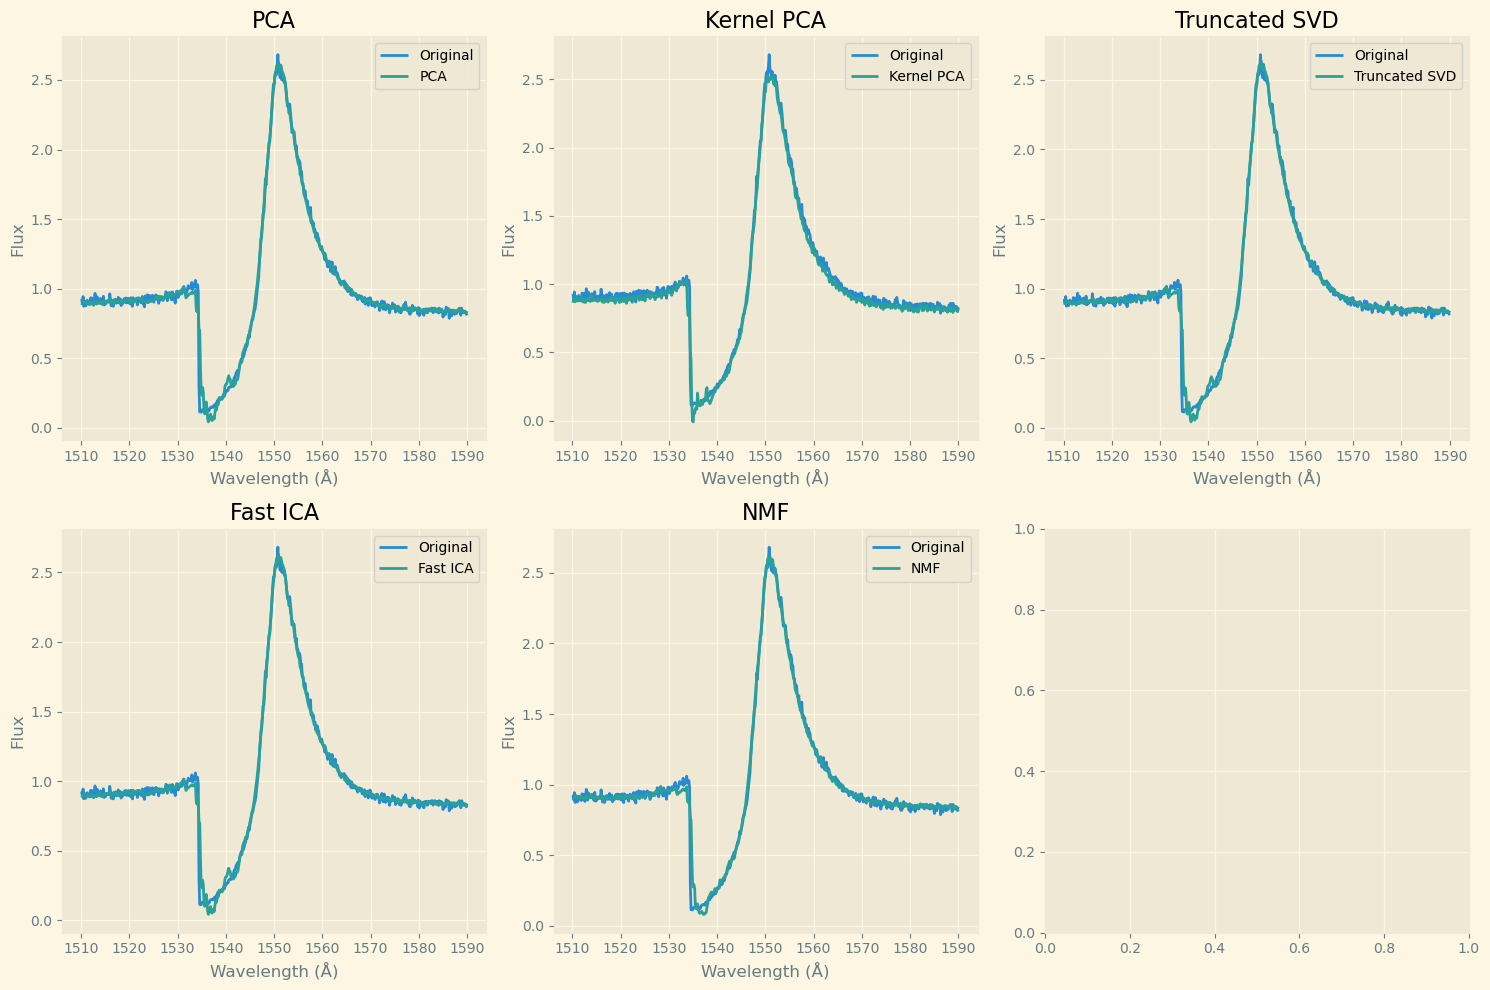

In [85]:
# Plot random spectrum and reconstructed spectrum
random_spectrum = np.random.randint(0, len(data_test))
random_spectrum = 8
print(random_spectrum, 'random index')
print('this corresponds to grid point', grid_points_test[random_spectrum])

# Plotting the random spectrm, the reconstructed spectrum and another method spectrum
fig, axs = plt.subplots(2,3, figsize=(15,10))
for i, ax in enumerate(axs.flatten()):
    if i < len(reconstruct):
        ax.plot(wavelengths, data_test[random_spectrum], label='Original')
        ax.plot(wavelengths, reconstruct[i][random_spectrum], label=labels[i])
        ax.set_title(labels[i])
        ax.set_xlabel('Wavelength (Å)')
        ax.set_ylabel('Flux')
        ax.legend()
plt.tight_layout()
plt.show()
#plt.plot(wavelengths, data_test[random_spectrum], label='Original')
#plt.plot(wavelengths, reconstructed[random_spectrum], label='PCA')
##plt.plot(wavelengths, reconstructed2[random_spectrum], label='Kernel PCA')
#plt.plot(wavelengths, reconstructed3[random_spectrum], label='truncated SVD')
#plt.plot(wavelengths, reconstructed4[random_spectrum], label='Factor Analysis')
#plt.plot(wavelengths, reconstructed5[random_spectrum], label='Fast ICA')
#plt.plot(wavelengths, reconstructed6[random_spectrum], label='NMF')
#plt.title('Random Spectrum')
#plt.xlabel('Wavelength (Å)')
#plt.ylabel('Flux')
#plt.legend()
#plt.show()

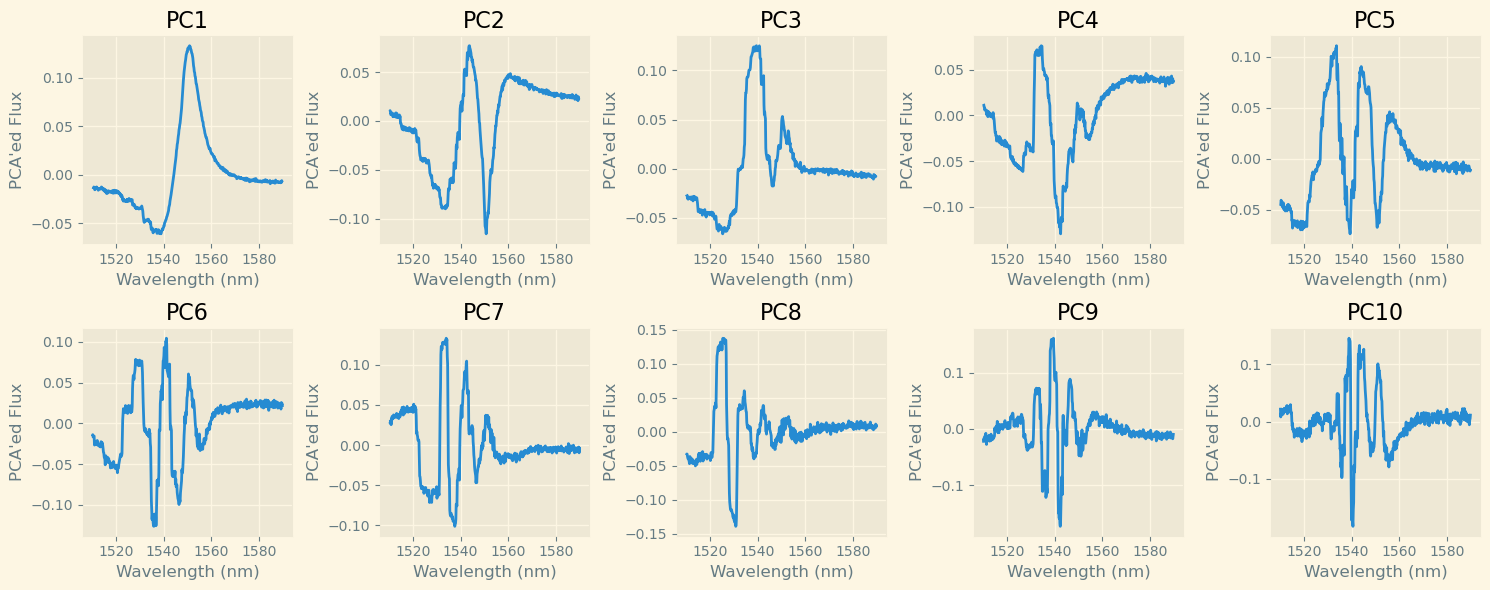

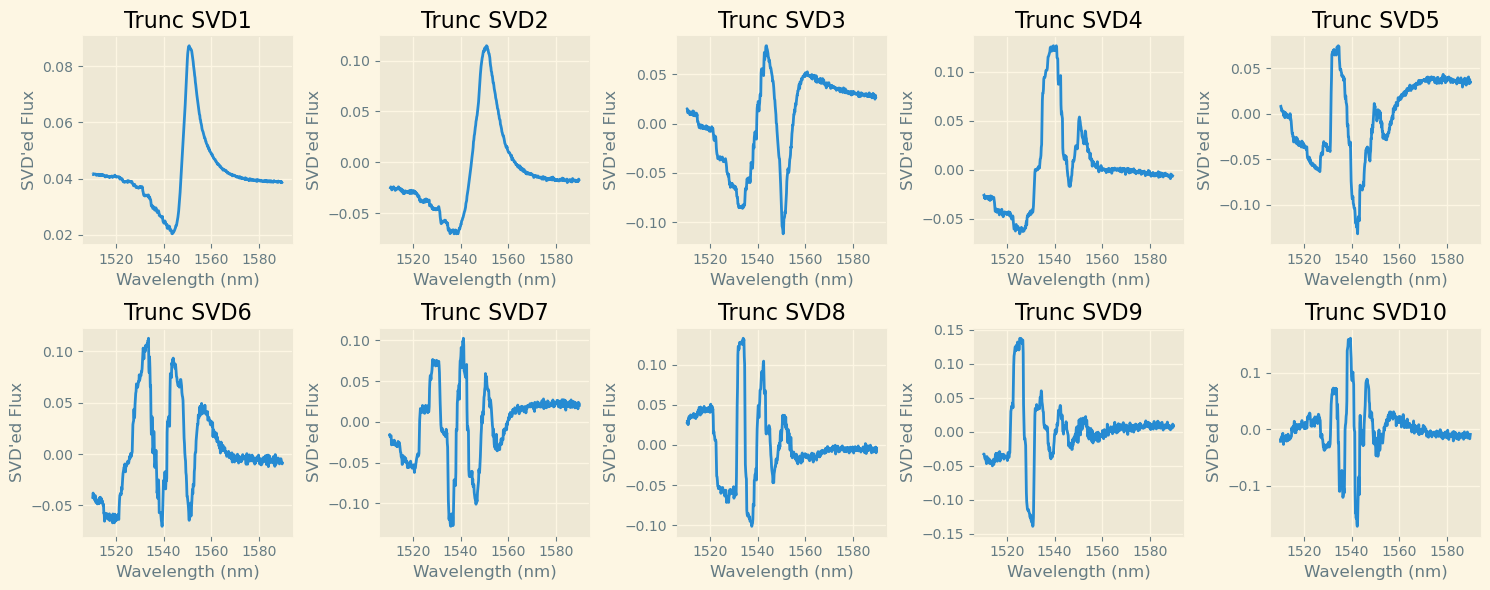

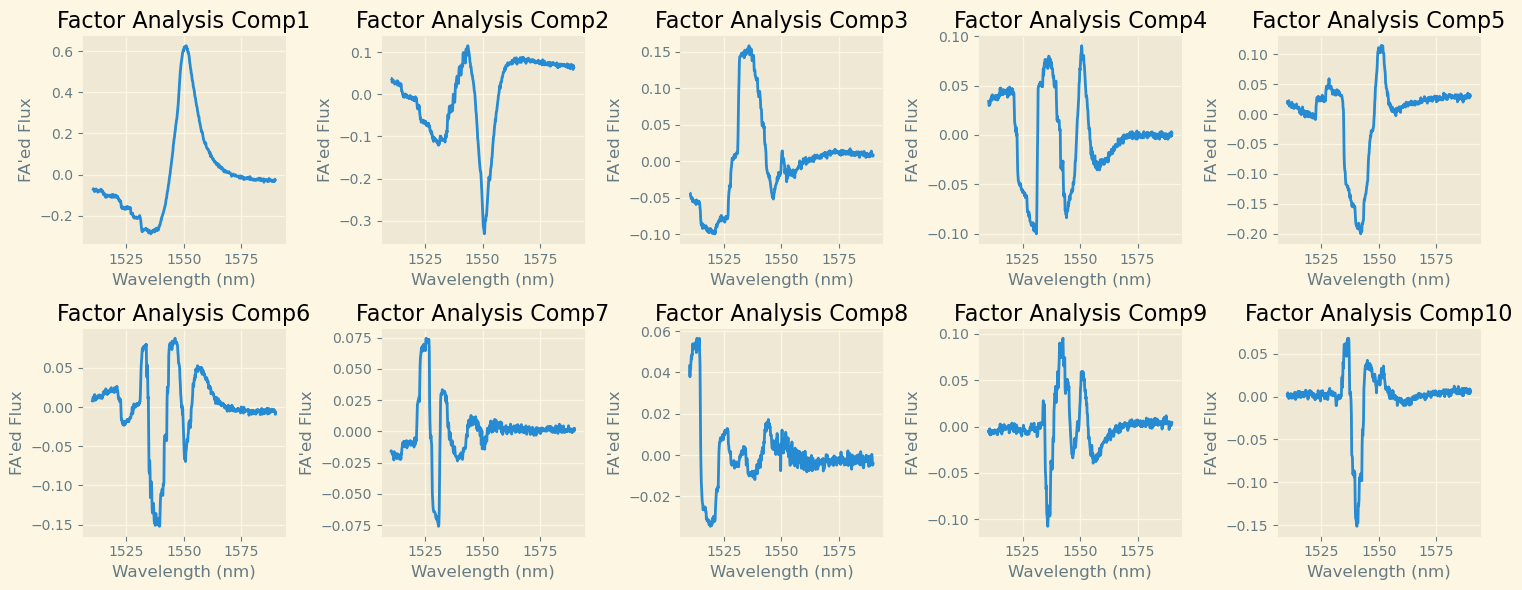

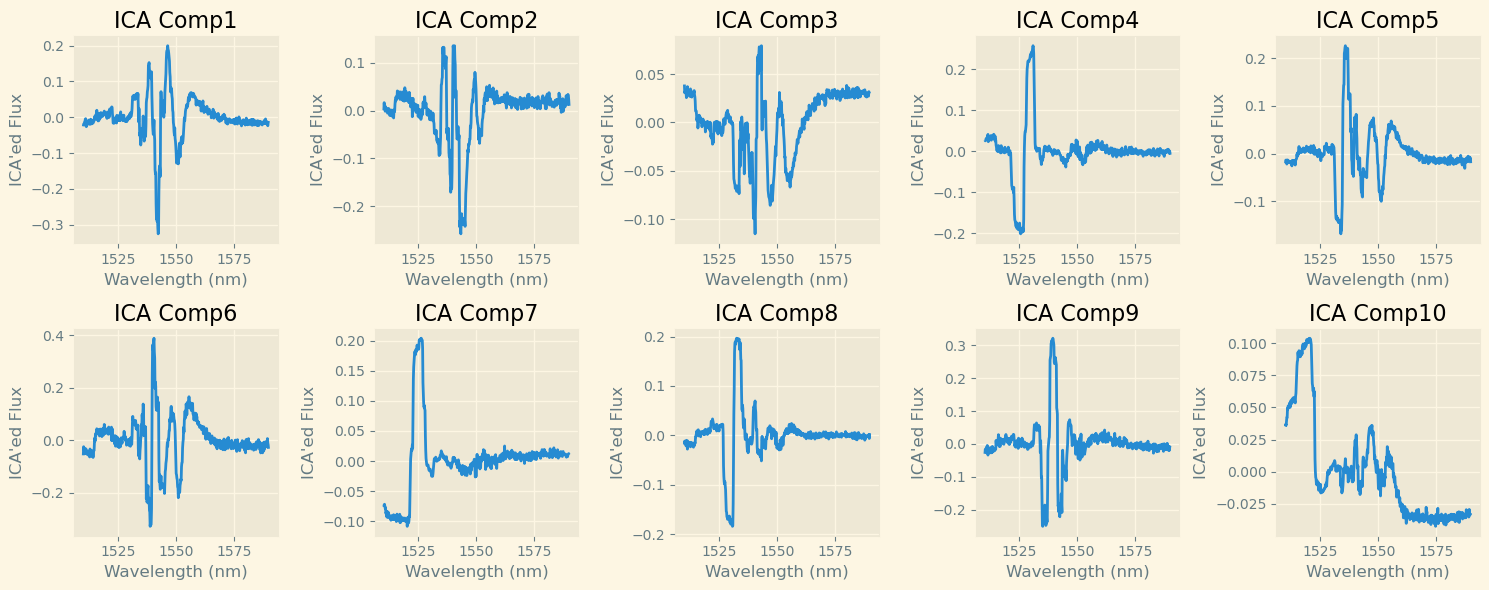

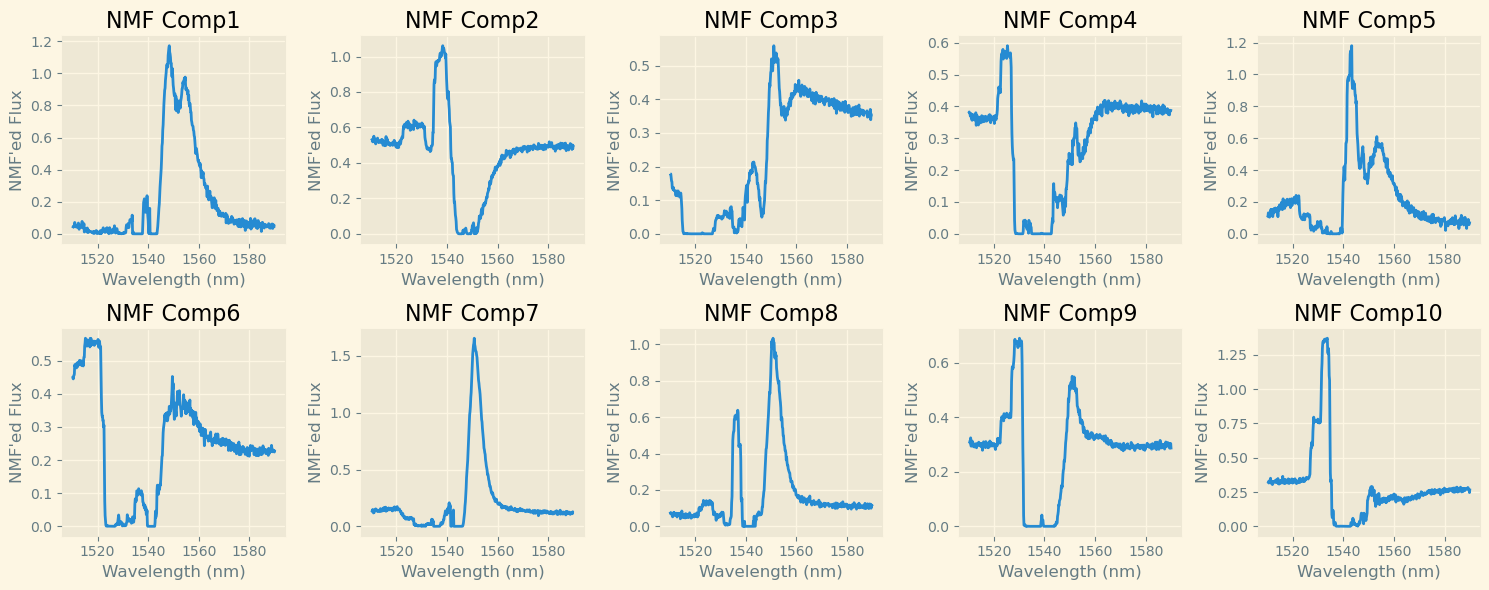

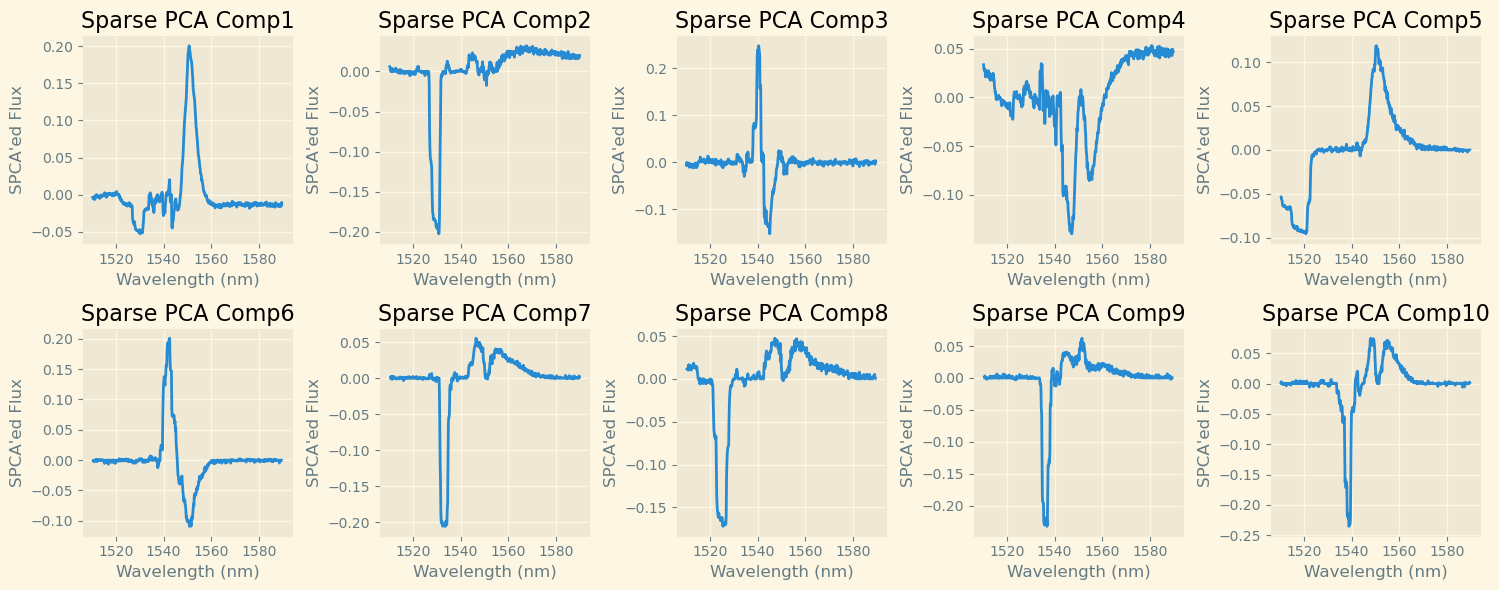

In [86]:
# Other plotting functions for eigenspectra and weights for PCA

# A mulitaxis plot of the first 10 principal components varying subplots to the correct number of components
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    ax.plot(wavelengths, eigenspectra[i])
    ax.set_title(f'PC{i+1}')
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel("PCA'ed Flux")
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    ax.plot(wavelengths, eigenspectra3[i])
    ax.set_title(f'Trunc SVD{i+1}')
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel("SVD'ed Flux")
plt.tight_layout()
plt.show()

# A mulitaxis plot of the first 10 principal components varying subplots to the correct number of components
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    ax.plot(wavelengths, eigenspectra4[i])
    ax.set_title(f'Factor Analysis Comp{i+1}')
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel("FA'ed Flux")
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    ax.plot(wavelengths, eigenspectra5[i])
    ax.set_title(f'ICA Comp{i+1}')
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel("ICA'ed Flux")
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    ax.plot(wavelengths, eigenspectra6[i])
    ax.set_title(f'NMF Comp{i+1}')
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel("NMF'ed Flux")
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    ax.plot(wavelengths, eigenspectra7[i])
    ax.set_title(f'Sparse PCA Comp{i+1}')
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel("SPCA'ed Flux")
plt.tight_layout()
plt.show()

### KERNEL PCA (no test data, all data used as training)

(125, 10) weights (grid points, components)


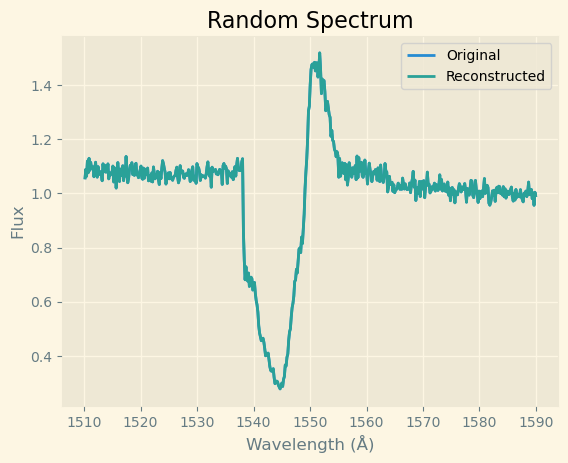

In [4]:
from sklearn.decomposition import KernelPCA

data = normalised_grid

kernel_pca = KernelPCA(n_components=10, kernel='poly', gamma=0.1, degree = 3, fit_inverse_transform=True)
transformed_data = kernel_pca.fit_transform(data)
print(transformed_data.shape, 'weights (grid points, components)')
reconstructed = kernel_pca.inverse_transform(transformed_data) # Reconstructing the data from the weights

# Plot random spectrum and reconstructed spectrum
random_spectrum = np.random.randint(0, len(data))
random_spectrum = 36

plt.plot(wavelengths, data[random_spectrum], label='Original')
plt.plot(wavelengths, reconstructed[random_spectrum], label='Reconstructed')

plt.title('Random Spectrum')
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux')
plt.legend()
plt.show()